In [10]:
!pip install ortools
import os
import random
import numpy as np
import pandas as pd
import math
import csv
from matplotlib import pyplot as plt
import datetime
import time
# from matplotlib import pyplot as plt

from ortools.constraint_solver import pywrapcp

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [11]:
# GLOBAL VARIABLES
# @variable years_in_operation [integer] operation period of wind farm suppositioned in model in years
# @variable cost_per_watt_hour_lost [float] opportunity cost of energy lost to cable loss in USD/Wh
# @variable cable_max [integer] cable max capacity in volts
# @variable loop_max [integer] maximum number of loops that can be attatched to substation
# @variable cable_cost_per_distance [integer] cost of initial costs of cable in USD/m
years_in_operation = 25
cost_per_watt_hour_lost = 10
cable_max = 35
loop_max = 4
cable_cost_per_distance = 10000000

def optimization_step(wind_farm_with_cabling, cable_loss_constant, cable_crossing_constant):
    cost_matrix = (wind_farm_with_cabling.wind_farm.distance_matrix * cable_cost_per_distance) + (wind_farm_with_cabling.cable_voltage_matrix * cable_loss_constant) + (wind_farm_with_cabling.cable_crossing_matrix * cable_crossing_constant)

    def solution_to_loops(data, manager, routing, solution):
        loops = []
        for loop_id in range(data['loop_max']):
            loop = []
            index = routing.Start(loop_id)
            while not routing.IsEnd(index):
                loop.append(manager.IndexToNode(index))
                index = solution.Value(routing.NextVar(index))
            loops.append(loop)
        return loops

    def create_data_model():
        generated = [node.generated_power for node in wind_farm_with_cabling.wind_farm.nodes]
        data = {}
        data['cost_matrix'] = cost_matrix
        data['loop_max'] = loop_max
        data['depot'] = wind_farm_with_cabling.wind_farm.substation.id
        data['generated'] = generated
        return data

    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(wind_farm_with_cabling.wind_farm.nodes), data['loop_max'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index) 
        to_node = manager.IndexToNode(to_index)
        return data['cost_matrix'][from_node][to_node]
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    def demand_callback(index):
        node = manager.IndexToNode(index)
        return data['generated'][node]
    
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  
        [cable_max for count in range(loop_max)], 
        True,  
        'generated')
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    capacity = routing.GetDimensionOrDie('generated')
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = 10
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        loops = solution_to_loops(data, manager, routing, solution)
        output_WindFarmWithCabling = WindFarmWithCabling(wind_farm_with_cabling.wind_farm, cabling=Cabling(loops=loops, nodes=wind_farm_with_cabling.wind_farm.nodes))
        print(loops)
        if output_WindFarmWithCabling.cabling.loops == wind_farm_with_cabling.cabling.loops:
            print('same')
        return output_WindFarmWithCabling
        
    else: 
        print('No solution found!')

# csv has columns of [iteration_id, cable_loss_cost, cable_initial_cost, cable_crossing_count, cable_cost]
def output_data(wind_farm_with_cabling, image_output_directory, csv_output_directory, iteration_id):
    data = [iteration_id, wind_farm_with_cabling.cable_loss_cost, wind_farm_with_cabling.cable_initial_cost, wind_farm_with_cabling.cable_crossing_count, wind_farm_with_cabling.cable_cost]

    with open(csv_output_directory, 'a') as file:
        writer = csv.writer(file)
        writer.writerow(data)
    
    plt.figure(figsize=(10,10))
    for node in wind_farm_with_cabling.wind_farm.nodes:
        plt.scatter(node.x_coordinate, node.y_coordinate, s=5)
        plt.text(node.x_coordinate, node.y_coordinate, node.id)
    for arc in wind_farm_with_cabling.cabling.arcs:
        plt.plot([list(arc.node_frozenset)[0].x_coordinate,list(arc.node_frozenset)[1].x_coordinate],[list(arc.node_frozenset)[0].y_coordinate,list(arc.node_frozenset)[1].y_coordinate], c=str(min(0.9, -(arc.voltage/cable_max)+1)),linewidth=3)
    plt.savefig("{image_output_directory}/{image_file_name}.png".format(image_output_directory=image_output_directory, image_file_name=iteration_id))

def input_data(data_directory):
    nodes = []
    with open(data_directory, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            nodes.append(Node(int(row[0]),int(row[1]),int(row[2]),int(row[3]),bool(int(row[4])),bool(int(row[5]))))
    cabling = Cabling(loops=[],nodes=nodes)
    wind_farm = WindFarm(nodes=nodes)
    wind_farm_with_cabling = WindFarmWithCabling(wind_farm=wind_farm, cabling=cabling)
    return wind_farm_with_cabling


def onSegment(node_1, node_2, node_3):
    if ( (node_2.x_coordinate <= max(node_1.x_coordinate, node_3.x_coordinate)) and (node_2.x_coordinate >= min(node_1.x_coordinate, node_3.x_coordinate)) and 
           (node_2.y_coordinate <= max(node_1.y_coordinate, node_3.y_coordinate)) and (node_2.y_coordinate >= min(node_1.y_coordinate, node_3.y_coordinate))):
        return True
    return False

def orientation(node_1, node_2, node_3):
      
    val = (float(node_2.y_coordinate - node_1.y_coordinate) * (node_3.x_coordinate - node_2.x_coordinate)) - (float(node_2.x_coordinate - node_1.x_coordinate) * (node_3.y_coordinate - node_2.y_coordinate))
    if (val > 0):
        return 1
    elif (val < 0):
        return 2
    else:
        return 0

def doIntersect(segment_1_a,segment_1_b,segment_2_a,segment_2_b):
    # Find the 4 orientations required for 
    # the general and special cases
    o1 = orientation(segment_1_a, segment_1_b, segment_2_a)
    o2 = orientation(segment_1_a, segment_1_b, segment_2_b)
    o3 = orientation(segment_2_a, segment_2_b, segment_1_a)
    o4 = orientation(segment_2_a, segment_2_b, segment_1_b)
  
    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True
  
    # Special Cases
  
    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and onSegment(segment_1_a, segment_2_a, segment_1_b)):
        return True
  
    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and onSegment(segment_1_a, segment_2_b, segment_1_b)):
        return True
  
    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and onSegment(segment_2_a, segment_1_a, segment_2_b)):
        return True
  
    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and onSegment(segment_2_a, segment_1_b, segment_2_b)):
        return True
  
    # If none of the cases
    return False

In [12]:
# @attribute id [integer] unique identifier starting from 0 with step 1
# @attribute x_coordinate [integer] integer value of x coordinate in UTM
# @attribute x_coordinate [integer] integer value of y coordinate in UTM
# @attribute generated_power [integer] integer value of power generated at node in V
# @attribute is_turbine [boolean] boolean true if node is turbine
# @attribute is_substation [boolean] boolean true if node is substation
class Node:
    def __init__(self, id, x_coordinate, y_coordinate, generated_power, is_turbine=False, is_substation=False):
        self.id = id
        self.x_coordinate = x_coordinate
        self.y_coordinate = y_coordinate
        self.generated_power = generated_power
        self.is_turbine = is_turbine
        self.is_substation = is_substation

# @attribute nodes [list<Node>] list of nodes sorted by id
# @attribute turbines [list<Node>] list of Node objects where is_turbine==True
# @attribute substation [Node] Node object where is_substation==True
# @attribute distance_matrix [np.Array] numpy array of manhattan distance between nodes indexed by id
# @attribute list_of_sets_of_crossing_node_sets [list<frozenset<frozenset<Node>>>] list of frozensets of frozensets of nodes where node pairs cross
class WindFarm:
    def __init__(self, nodes):
        self.nodes = sorted(nodes, key=lambda node: node.id)
        self.turbines = [node for node in self.nodes if node.is_turbine == True]
        self.substation = next((node for node in self.nodes if node.is_substation == True), None)
        self.generate_distance_matrix()
        self.set_list_of_sets_of_crossing_node_sets()

    def generate_distance_matrix(self):
        x_coordinates = [node.x_coordinate for node in self.nodes]
        y_coordinates = [node.y_coordinate for node in self.nodes]
        distance_matrix = []

        for i in range(len(self.nodes)):
            distance_array = []
            for j in range(len(self.nodes)):
                distance_array.append(abs(x_coordinates[i]-x_coordinates[j]) + abs(y_coordinates[i]-y_coordinates[j]))
            distance_matrix.append(distance_array)

        self.distance_matrix = np.array(distance_matrix)
    
    #TODO: WIP
    def set_list_of_sets_of_crossing_node_sets(self):
        list_of_sets_of_crossing_node_sets = []
        for segment_1_a in self.nodes:
            for segment_1_b in self.nodes:
                if segment_1_a != segment_1_b:
                    for segment_2_a in self.nodes:
                        for segment_2_b in self.nodes:
                            if segment_2_a != segment_2_b:
                                if doIntersect(segment_1_a,segment_1_b,segment_2_a,segment_2_b):
                                    list_of_sets_of_crossing_node_sets.append(frozenset({frozenset({segment_1_a, segment_1_b}),frozenset({segment_2_a,segment_2_b})}))
                                    

        self.list_of_sets_of_crossing_node_sets = list_of_sets_of_crossing_node_sets

# @attribute node_frozenset [frozenset] frozenset of the two nodes that comprise the edges of the arc
# @attibute voltage [integer] voltage running through arc, defaults to 0
class Arc:
    def __init__(self, node_frozenset, voltage=0):
        self.node_frozenset = node_frozenset
        self.voltage = voltage
        
# @attribute loops [list<list<integer>>] list of lists of nodes belonging to loops by id, starting with 0
# @attribute arcs [list<Arc>] list of arcs belonging to cabling
class Cabling:   
    def __init__(self, loops, nodes):
        self.loops = loops
        self.nodes = nodes
        self.set_arcs()

    def set_arcs(self):
        loops = self.loops
        arcs = []
        for loop in loops:
            loop.append(loop[0])
        for loop in loops:
            loop_nodes = [next(node for node in self.nodes if node.id == i) for i in loop]
            # when number of nodes attatched to loop is less than 3, generate 0 arcs
            if len(loop_nodes) < 3:
                pass
            # when number of nodes attatched to loop is 3, generate 1 arc
            elif len(loop_nodes) == 3:
                arcs.append( Arc(node_frozenset = frozenset({loop_nodes[0], loop_nodes[1]}), voltage=loop_nodes[1].generated_power))
            # when number of nodes attatched to loop is even
            elif len(loop_nodes)%2 == 0:
                # generate arcs excluding central arc
                for index in range(1,len(loop_nodes)-1):
                    path_1 = loop_nodes[:index+1]
                    path_2 = loop_nodes[index:]
                    if len(path_1) > len(path_2):
                        voltage = 0
                        for node in loop_nodes[int(len(loop_nodes)/2):index+1]:
                            voltage += node.generated_power
                        arcs.append(Arc(node_frozenset= frozenset({loop_nodes[index], loop_nodes[index+1]}), voltage=voltage))
                    else:
                        voltage = 0
                        for node in loop_nodes[index:int(len(loop_nodes)/2)]:
                            voltage += node.generated_power
                        arcs.append(Arc(node_frozenset = frozenset({loop_nodes[index], loop_nodes[index-1]}), voltage=voltage))
                # generate central arc
                arcs.append(Arc(node_frozenset= frozenset({loop_nodes[int(len(loop_nodes)/2)], loop_nodes[int(len(loop_nodes)/2 - 1)]}), voltage=0))
            # when number of nodes attatched to loop is even
            else:
                center_node_index = int(len(loop_nodes)/2)
                for index in range(1,len(loop_nodes)-1):
                    path_1 = loop_nodes[:index+1]
                    path_2 = loop_nodes[index:]
                    if len(path_1) > len(path_2):
                        voltage = 0
                        for node in loop_nodes[center_node_index+1:index+1]:
                            voltage += node.generated_power
                        arcs.append(Arc(node_frozenset= frozenset({loop_nodes[index], loop_nodes[index+1]}), voltage=voltage))
                    #TODO: refactor this section so that the power generated from the central node is carried by that with the least cable loss
                    # voltage from central node is carried by path_2
                    else:
                        voltage = 0
                        for node in loop_nodes[index:center_node_index+1]:
                            voltage += node.generated_power
                        arcs.append(Arc(node_frozenset = frozenset({loop_nodes[index], loop_nodes[index-1]}), voltage=voltage))
                arcs.append(Arc(node_frozenset= frozenset({loop_nodes[center_node_index], loop_nodes[center_node_index+1]}), voltage=0))
        self.arcs = arcs


# @attribute wind_farm [WindFarm] wind farm on which WindFarmWithCabling instance is made
# @attribute cabling [Cabling] cabling on which WindFarmWithCabling instance is made
# @attribute cable_crossing_pairs [list<frozenset<frozenset<Node>>>] list of pairs of pairs of nodes belonging to instance of WindFarmWithCabling where arcs cross  e.g. [{{1,2},{3,4}},{{6,7},{8,9}}]
# @attribute cable_voltage_matrix [np.Array] numpy array of voltage between nodes indexed by id
# @attribute cable_crossing_matrix [np.Array] numpy array of 0/1 binary variables indicating cable crossing occurance between nodes indexed by id
# @attribute cable_loss_cost [float] cable loss incurred throughout the lifetime by this instance of WindFarmWithCabling in USD
# @attribute cable_initial_cost [float] cable cost (installation/equipment) incurred by this instance of WindFarmWithCabling in USD
# @attribute cable_crossing_count [int] number of cable crossings
# @attribute cable_cost [float] sum of costs incurred throughout lifetime of this instance WindFarmWithCabling in USD (sum of cable_loss and cable_cost)
class WindFarmWithCabling:
    def __init__(self, wind_farm, cabling):
        self.wind_farm = wind_farm
        self.cabling = cabling
        self.set_cable_crossing_pairs()
        self.set_cable_voltage_matrix()
        self.set_cable_crossing_matrix()
        self.set_cable_initial_cost()
        self.set_cable_loss_cost()
        self.set_cable_crossing_count()
        self.set_cable_cost()

    def set_cable_crossing_pairs(self):
        arc_pairs = set()
        
        for arc_i in self.cabling.arcs:
            for arc_j in self.cabling.arcs:
                if arc_i != arc_j:
                    arc_pairs.add(frozenset({frozenset({list(arc_i.node_frozenset)[0],list(arc_i.node_frozenset)[1]}),frozenset({list(arc_j.node_frozenset)[0],list(arc_j.node_frozenset)[1]})}))
        list_of_arc_pairs = list(arc_pairs)

        self.cable_crossing_pairs = [node_pair for node_pair in list_of_arc_pairs if node_pair in self.wind_farm.list_of_sets_of_crossing_node_sets]
    
    def set_cable_voltage_matrix(self):
        cable_voltage_matrix = np.zeros((len(self.wind_farm.nodes),len(self.wind_farm.nodes)))
        for arc in self.cabling.arcs:
            index_0 = list(arc.node_frozenset)[0].id
            index_1 = list(arc.node_frozenset)[1].id
            cable_voltage_matrix[index_0][index_1] = arc.voltage
            cable_voltage_matrix[index_1][index_0] = arc.voltage
        self.cable_voltage_matrix = cable_voltage_matrix
    
    def set_cable_crossing_matrix(self):
        cable_crossing_matrix = np.zeros((len(self.wind_farm.nodes),len(self.wind_farm.nodes)))
        for cable_crossing_pair in self.cable_crossing_pairs:
            for node_frozenset in list(cable_crossing_pair):
                index_0 = list(node_frozenset)[0].id
                index_1 = list(node_frozenset)[1].id
                cable_crossing_matrix[index_0][index_1] += 1
                cable_crossing_matrix[index_1][index_0] += 1
        self.cable_crossing_matrix = cable_crossing_matrix

    def set_cable_initial_cost(self):
        cable_length = 0
        for arc in self.cabling.arcs:
            cable_length += self.wind_farm.distance_matrix[list(arc.node_frozenset)[0].id, list(arc.node_frozenset)[1].id]
        cable_initial_cost = cable_length * cable_cost_per_distance
        self.cable_initial_cost = cable_initial_cost
    
    def set_cable_crossing_count(self):
        self.cable_crossing_count = np.sum(self.cable_crossing_matrix)
               
    def set_cable_loss_cost(self):
        cable_loss_cost = 0
        print(self.cabling.arcs)
        for arc in self.cabling.arcs:
            #TODO: Discuss cable loss calculation
            cable_loss_cost += self.wind_farm.distance_matrix[list(arc.node_frozenset)[0].id, list(arc.node_frozenset)[1].id]
            # self.wind_farm.distance_matrix[list(arc.node_frozenset)[0].id, list(arc.node_frozenset)[1].id] * years_in_operation * cost_per_watt_hour_lost * 8760
        self.cable_loss_cost = cable_loss_cost
    def set_cable_cost(self):
        self.cable_cost =  self.cable_loss_cost +  self.cable_initial_cost


 

cat: ./output/csv/./output/csv/2022-10-14-034620_output.csv: No such file or directory


[]
[<__main__.Arc object at 0x1216fe580>, <__main__.Arc object at 0x1216fe8b0>, <__main__.Arc object at 0x1216fe490>, <__main__.Arc object at 0x1216fe280>, <__main__.Arc object at 0x1216fe2e0>, <__main__.Arc object at 0x1216fea90>, <__main__.Arc object at 0x1216fe130>, <__main__.Arc object at 0x1216fe8e0>, <__main__.Arc object at 0x1216fe910>, <__main__.Arc object at 0x1216feb20>, <__main__.Arc object at 0x1216fe700>, <__main__.Arc object at 0x1216fec70>, <__main__.Arc object at 0x1216fe850>, <__main__.Arc object at 0x1216feaf0>, <__main__.Arc object at 0x1216fe730>, <__main__.Arc object at 0x1216fed30>, <__main__.Arc object at 0x1216fe9a0>, <__main__.Arc object at 0x1216fe520>, <__main__.Arc object at 0x1216fe610>, <__main__.Arc object at 0x1216feb80>, <__main__.Arc object at 0x1216fefd0>, <__main__.Arc object at 0x1216fe6a0>, <__main__.Arc object at 0x1216fe790>, <__main__.Arc object at 0x1216fe970>, <__main__.Arc object at 0x1216fea60>, <__main__.Arc object at 0x1216fe5e0>, <__main_

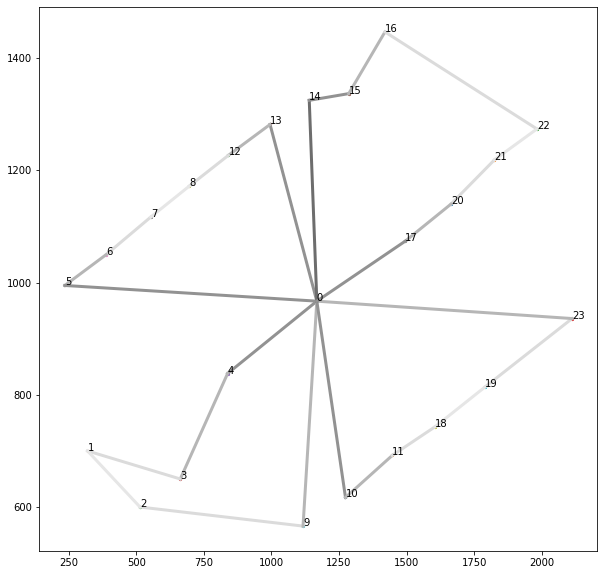

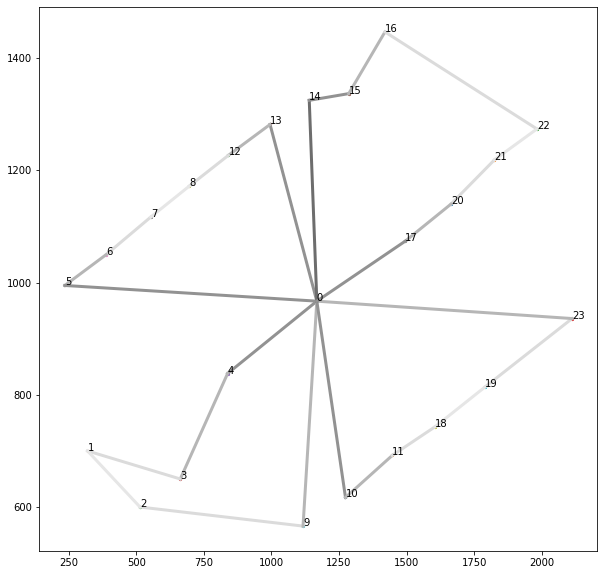

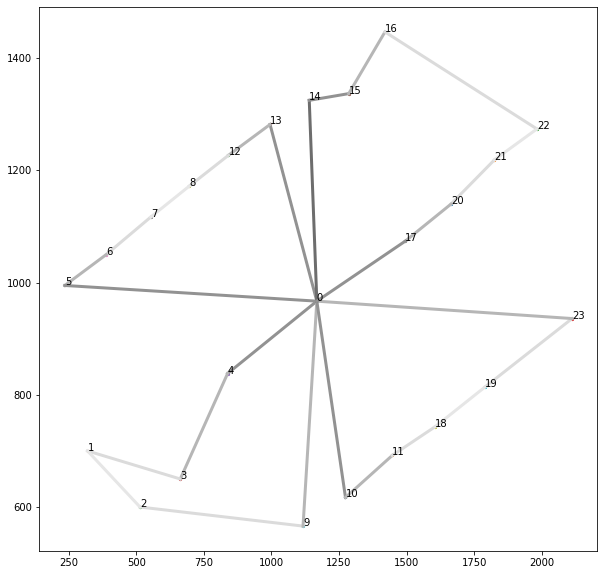

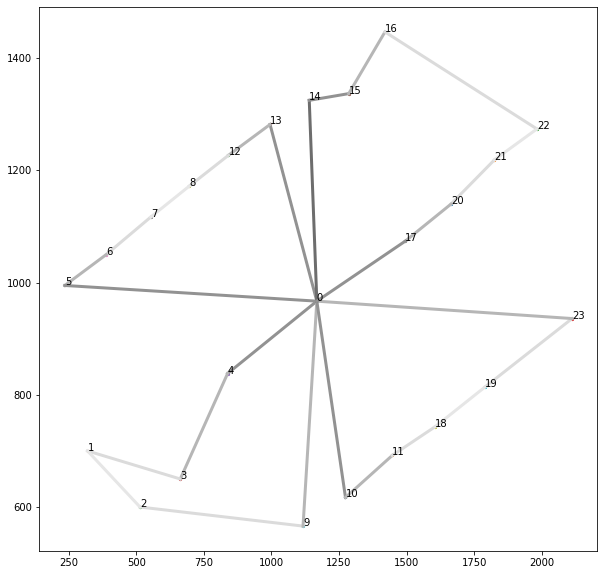

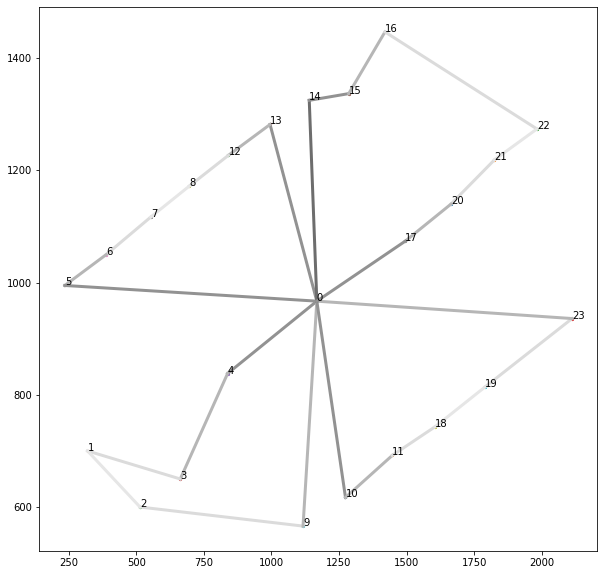

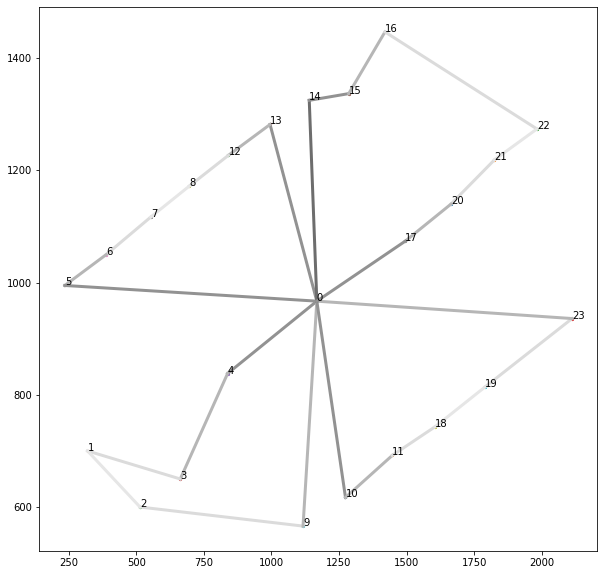

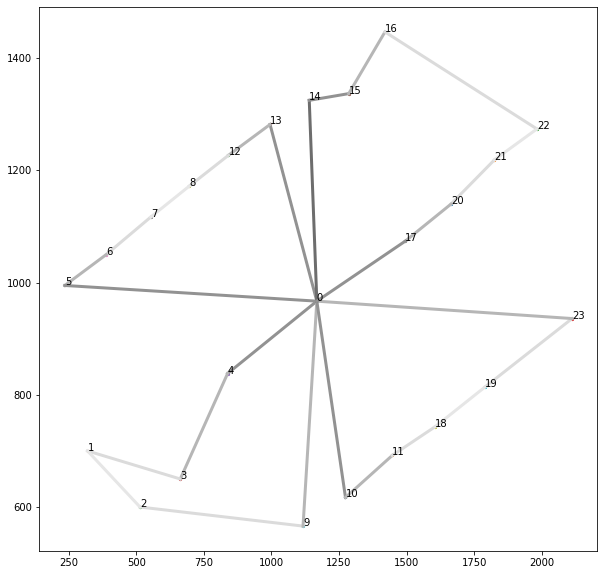

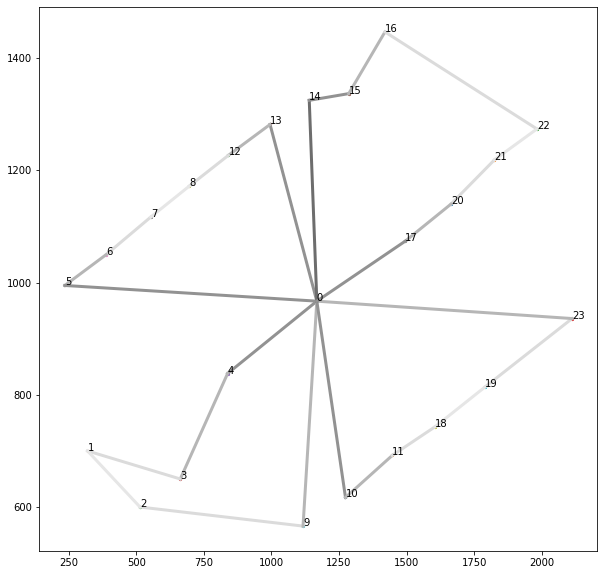

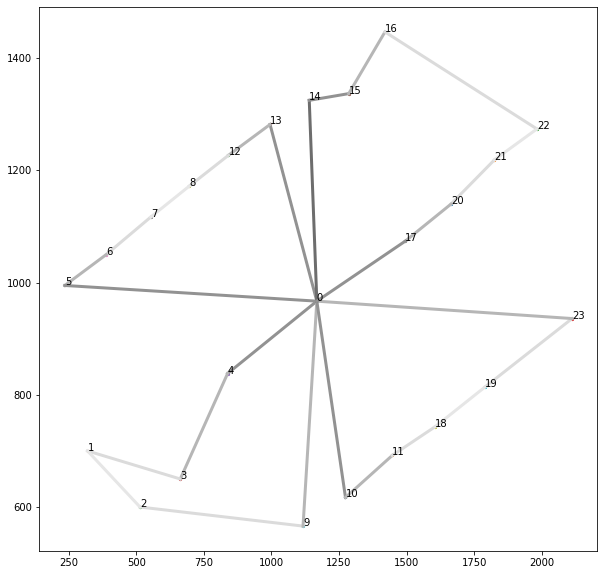

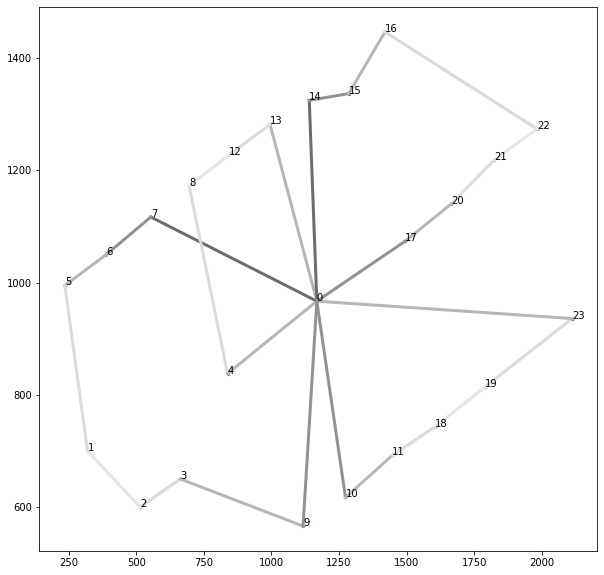

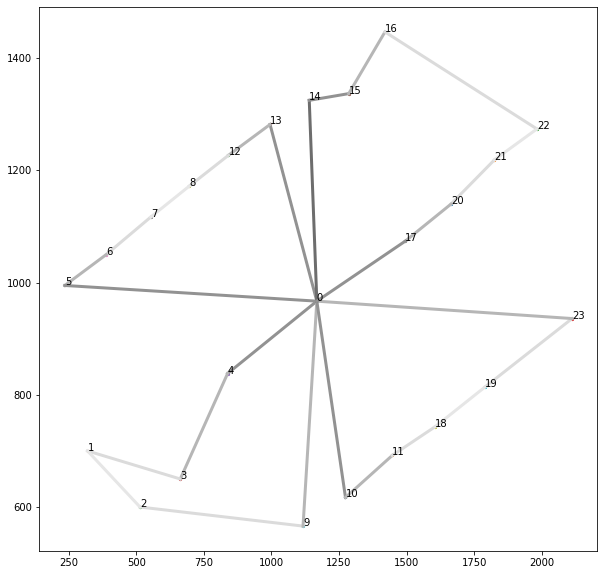

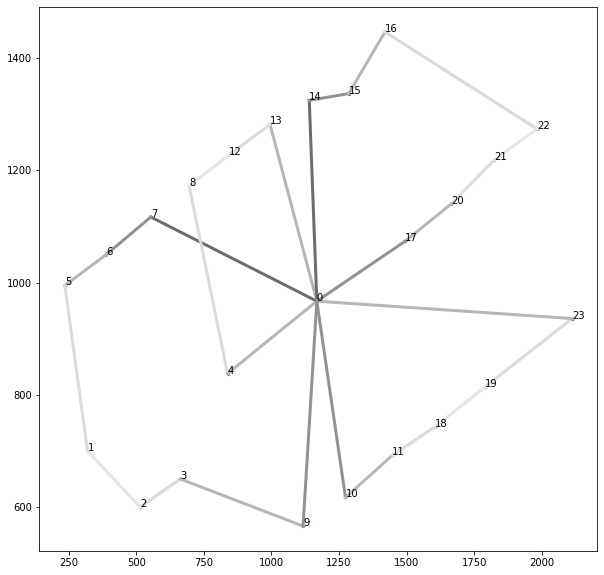

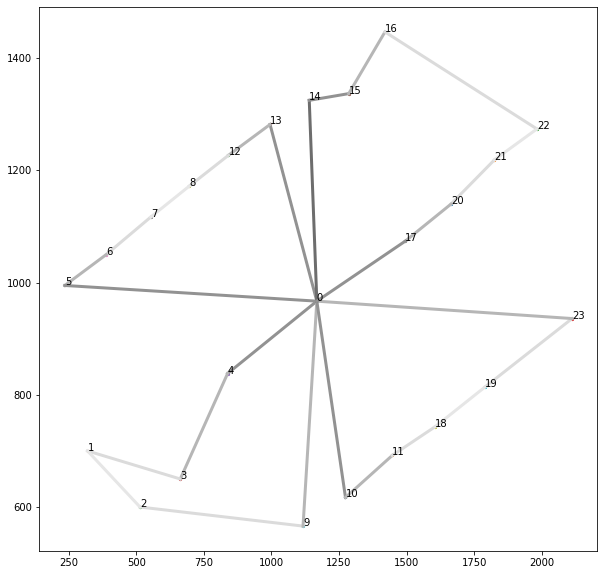

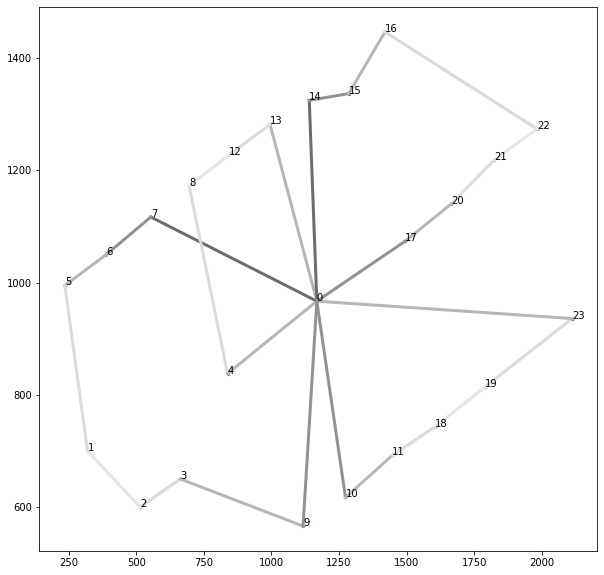

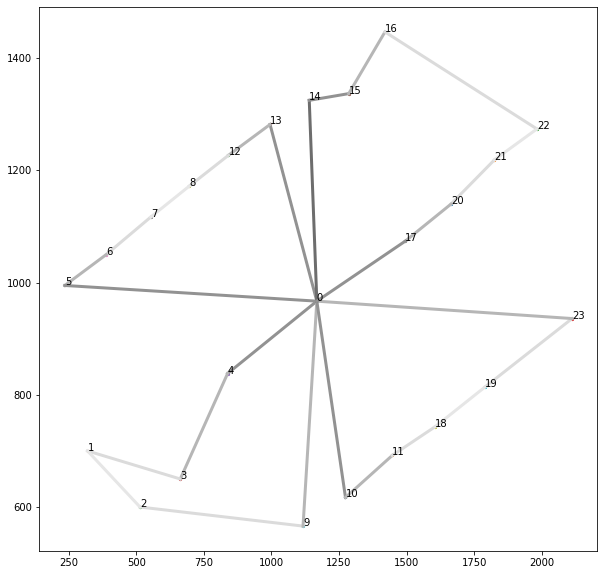

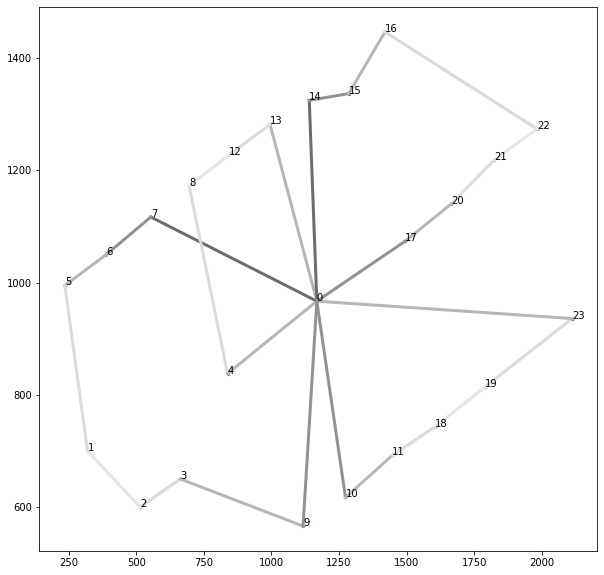

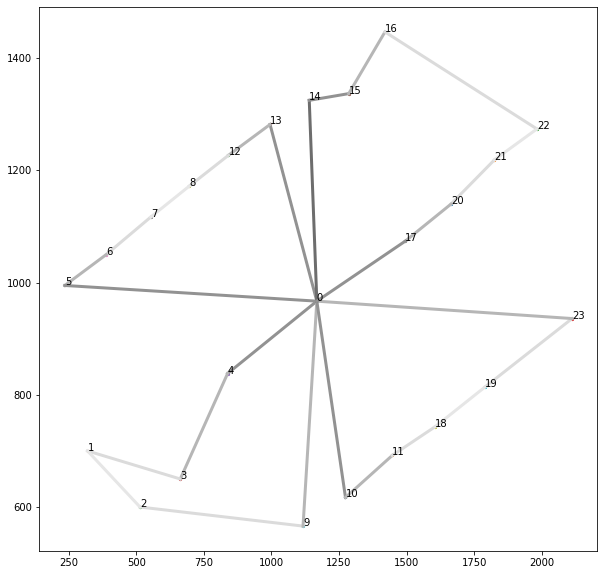

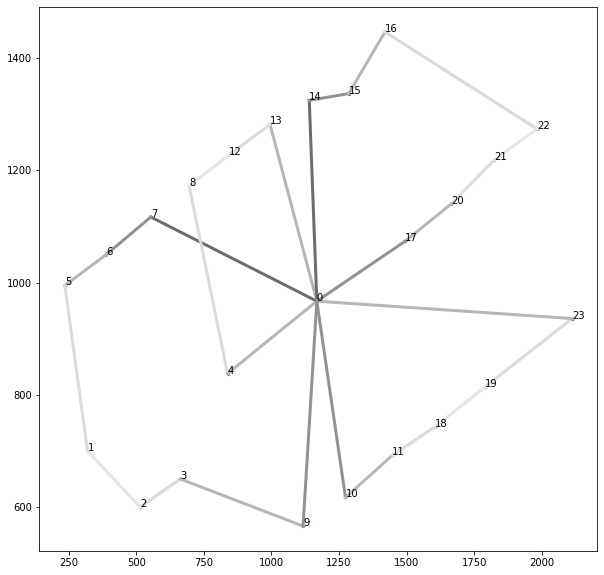

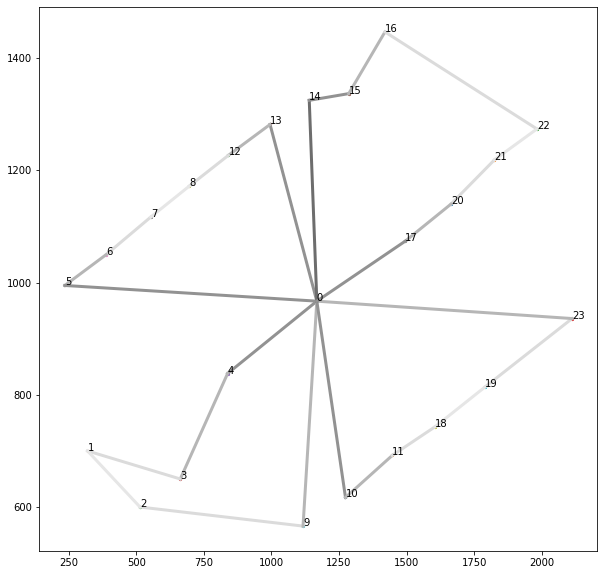

In [13]:
current_time = time.strftime("%Y-%m-%d-%H%M%S", time.gmtime())
image_output_directory = './output/images/{current_time}_images'.format(current_time=current_time)
csv_output_directory = './output/csv/{current_time}_output.csv'.format(current_time=current_time)
os.system('mkdir -p {image_output_directory}'.format(current_time=current_time, image_output_directory=image_output_directory))
os.system('cat ./output/csv/{csv_output_directory}'.format(current_time=current_time,csv_output_directory=csv_output_directory))
csv_header = ['iteration_id', 'cable_loss_cost', 'cable_initial_cost', 'cable_crossing_count', 'cable_cost']
with open(csv_output_directory, 'a') as file:
    writer = csv.writer(file)
    writer.writerow(csv_header)
wind_farm_with_cabling = input_data('./test_data.csv')
for iteration in range(1,20):
  wind_farm_with_cabling = optimization_step(wind_farm_with_cabling, cable_loss_constant=0.01*iteration, cable_crossing_constant=0)
  output_data(wind_farm_with_cabling, image_output_directory, csv_output_directory, iteration)
  print('iteration number{iteration}'.format(iteration=iteration))
  print(0.5*iteration)